## Importing Essential Libraries and Modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Defining Essential Functions

In [3]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def quality_labels(y):
    if y <= 4:
        return -1
    elif y <= 6:
        return 0
    else:
        return 1

### Defining Cache Directories

In [5]:
np_cache_dir = os.path.join('.', 'numpy_cache')
csv_cache_dir = os.path.join('.', 'csv_cache')

### Reading - and Presenting - the Data
* Vinho Verde Red Wine; Normalized; Outlier-Free

In [6]:
rn_wine = pd.read_csv(os.path.join(csv_cache_dir, 'red_clean.csv'), sep='\t').drop(['Unnamed: 0'], axis=1)
rn_wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
rn_wine_X = np.load(os.path.join(np_cache_dir, 'red_clean_X_normed.npy'))

#### Having the Quality Labels as is (For Regression)

In [8]:
rn_wine_y = np.load(os.path.join(np_cache_dir, 'red_clean_y.npy'))

#### Having the Quality Labels Separated into 3 Classes (For Classification)
* Bad (<=4), Mediocre (<=6), Good (<=10)

In [9]:
rn_wine_y_class = np.array(list(map(quality_labels, rn_wine_y)))

## Plot The Correlation Heatmap on the Original Dataset (just to eyeball the best - most correlated - features)

In [10]:
correlation = pd.DataFrame(rn_wine).corr()

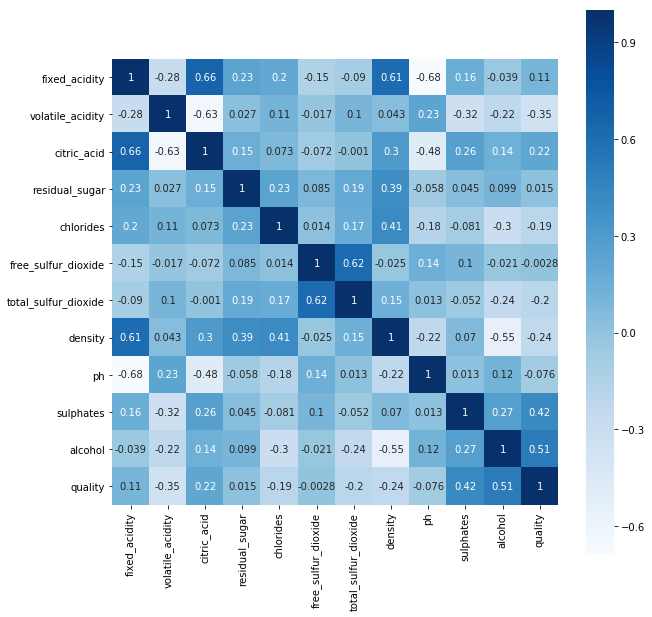

In [11]:
fig = plt.subplots(figsize=(10,10))
sns.heatmap(correlation,vmax=1,square=True,annot=True,cmap='Blues')

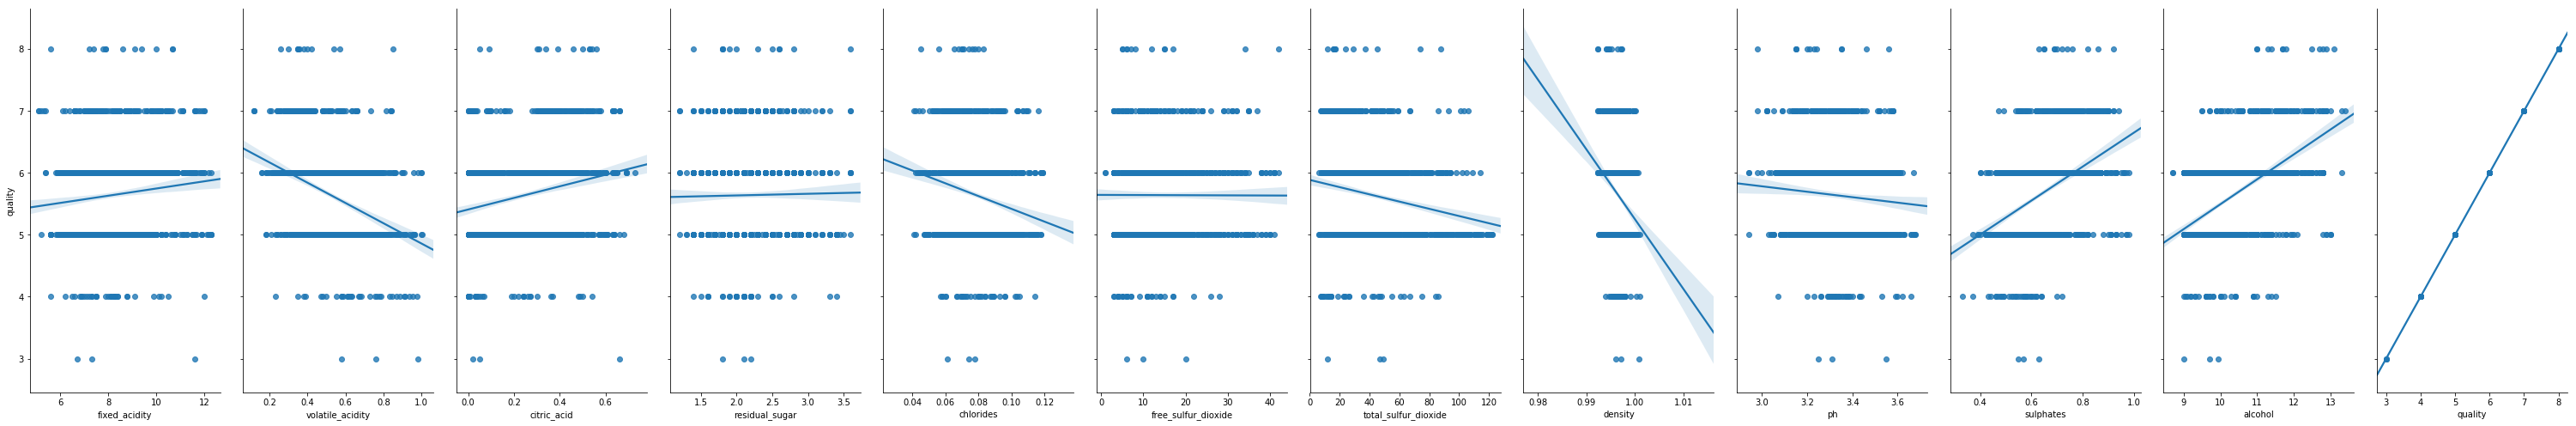

In [12]:
sns.pairplot(rn_wine, x_vars=rn_wine.columns,y_vars='quality',kind='reg',size=7,aspect=0.5)

## Cross Validation
#### Split our Dataset into 80/20 partition (80% Train / 20% Testing)

In [14]:
from tqdm import tqdm,tqdm_notebook
from sklearn.model_selection import RepeatedKFold

In [15]:
# x_train, x_test, y_train, y_test = train_test_split(rn_wine_X, rn_wine_y, 
#                                                     train_size=0.8, test_size=0.2, random_state=0)
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=100)

## Logistic Regression
* View the accuracy of regression having all features predict the rating value

In [21]:
regressor = LogisticRegression(solver='newton-cg', n_jobs=-1)
accuracy = np.array([])

for train_index, test_index in tqdm_notebook(rkf.split(rn_wine_X)):
    x_train, x_test = rn_wine_X[train_index], rn_wine_X[test_index]
    y_train, y_test = rn_wine_y[train_index], rn_wine_y[test_index]
    regressor.fit(x_train,y_train)
    
    accuracy = np.append(accuracy, [regressor.score(x_test, y_test)])

print ("Accuracy: {}%".format(accuracy.mean() * 100))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Accuracy: 60.03642628599557%


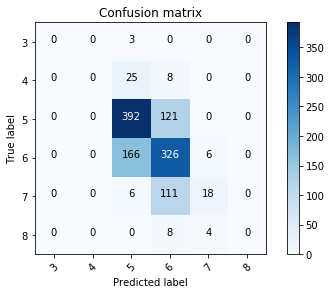

In [22]:
# make the predictions (y_hat) for the whole dataset
y_hat = regressor.predict(rn_wine_X)
# create the confusion matrix
cnf_matrix = confusion_matrix(rn_wine_y, y_hat)
# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=np.unique(rn_wine_y))

## k-Nearest Neighbors
* View the accuracy of regression having all features predict the rating value

In [26]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2, metric='minkowski', n_jobs=-1)
accuracy = np.array([])

for train_index, test_index in tqdm_notebook(rkf.split(rn_wine_X)):
    x_train, x_test = rn_wine_X[train_index], rn_wine_X[test_index]
    y_train, y_test = rn_wine_y_class[train_index], rn_wine_y_class[test_index]
    knn_classifier.fit(x_train,y_train)
    accuracy = np.append(accuracy, [knn_classifier.score(x_test, y_test)])

print ("Accuracy: {}%".format(accuracy.mean() * 100))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Accuracy: 87.50465876727259%


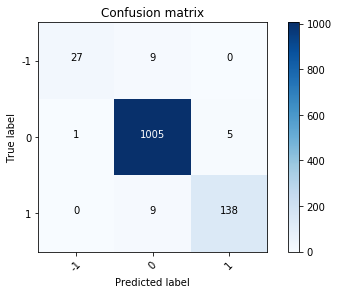

In [27]:
# make the predictions (y_hat) for the whole dataset
y_hat = knn_classifier.predict(rn_wine_X)
# create the confusion matrix
cnf_matrix = confusion_matrix(rn_wine_y_class, y_hat)
# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=np.unique(rn_wine_y_class))

##  (Theoretically) Increasing Prediction Accuracy Using Feature Selection
#### By using Feature Selection we (theoretically):
* Reduce Overfitting
* Improve the Accuracy of the used Predictor
* Reduces the Training Time (as we now train on a portion of the samples)

### Feature Selection using Univariate Selection (/w chi squared Evaluation Function)

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [29]:
# feature extraction
test = SelectKBest(score_func=chi2, k='all')
fit = test.fit(rn_wine_X, rn_wine_y)

# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

[ 1.836 11.757 12.11   0.165  3.673  2.518 12.973  5.123  0.777 14.627
 41.212]


In [30]:
[(list(rn_wine)[i], fit.scores_[i]) for i in range(len(fit.scores_))]

[('fixed_acidity', 1.8357119765974401),
 ('volatile_acidity', 11.75687486928301),
 ('citric_acid', 12.11046328925077),
 ('residual_sugar', 0.16497919929142701),
 ('chlorides', 3.6733692829859854),
 ('free_sulfur_dioxide', 2.5178165905689553),
 ('total_sulfur_dioxide', 12.973265656577839),
 ('density', 5.122834707404034),
 ('ph', 0.7770497708862234),
 ('sulphates', 14.627042946668888),
 ('alcohol', 41.21221748858245)]

##### Seeing the above result we estimate that 5 features are useful to our model
* volatile_acidity
* citric_acid
* total_sulfur_dioxide
* sulphates
* alcohol

### Feature Selection using Feature Importance (/w ExtraTreesClassifier)
* Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features.

In [31]:
from sklearn.ensemble import ExtraTreesClassifier

In [32]:
# feature extraction
model = ExtraTreesClassifier()
model.fit(rn_wine_X, rn_wine_y)

# summarize scores
print(model.feature_importances_)

[0.072 0.092 0.081 0.08  0.084 0.07  0.097 0.081 0.079 0.11  0.155]


In [33]:
[(list(rn_wine)[i], model.feature_importances_[i]) for i in range(len(model.feature_importances_))]

[('fixed_acidity', 0.07242870796296982),
 ('volatile_acidity', 0.09172451770008662),
 ('citric_acid', 0.08124216373565937),
 ('residual_sugar', 0.08035168299348586),
 ('chlorides', 0.08373289183361153),
 ('free_sulfur_dioxide', 0.0695584216060493),
 ('total_sulfur_dioxide', 0.09658568763917993),
 ('density', 0.08060670362338822),
 ('ph', 0.07881557895998312),
 ('sulphates', 0.11013209550687608),
 ('alcohol', 0.1548215484387102)]

##### Seeing the above result we estimate that 4 features are useful to our model
* volatile_acidity
* total_sulfur_dioxide
* sulphates
* alcohol

### Training with 5 features (SelectKBest Result)
* Transform the Dataset; Train; Compute Accuracy and Confusion Matrices
* Logistic Regression

In [34]:
# Feature Extraction
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(rn_wine_X, rn_wine_y)

# Transform the Dataset
rn_wine_X5 = fit.transform(rn_wine_X)

In [36]:
regressor = LogisticRegression(solver='newton-cg', n_jobs=-1)
accuracy = np.array([])

for train_index, test_index in tqdm_notebook(rkf.split(rn_wine_X5), total=rkf.get_n_splits()):
    x_train, x_test = rn_wine_X5[train_index], rn_wine_X5[test_index]
    y_train, y_test = rn_wine_y[train_index], rn_wine_y[test_index]
    regressor.fit(x_train,y_train)
    accuracy = np.append(accuracy, [regressor.score(x_test,y_test)])

print ("Accuracy: {}%".format(accuracy.mean() * 100))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))


Accuracy: 59.51696494497381%


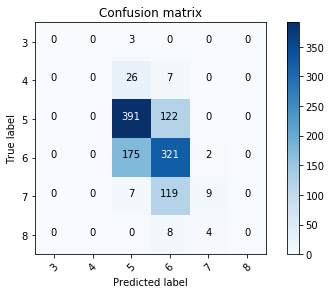

In [38]:
# make the predictions (y_hat) for the whole dataset
y_hat = regressor.predict(rn_wine_X5)
# create the confusion matrix
cnf_matrix = confusion_matrix(rn_wine_y, y_hat)
# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=np.unique(rn_wine_y))

* k-Nearest Neighbor Classifier

In [39]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2, metric='minkowski', n_jobs=-1)
accuracy = np.array([])

for train_index, test_index in tqdm_notebook(rkf.split(rn_wine_X5)):
    x_train, x_test = rn_wine_X5[train_index], rn_wine_X5[test_index]
    y_train, y_test = rn_wine_y_class[train_index], rn_wine_y_class[test_index]
    knn_classifier.fit(x_train,y_train)
    accuracy = np.append(accuracy, [knn_classifier.score(x_test,y_test)])

print ("Accuracy: {}%".format(accuracy.mean() * 100))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Accuracy: 87.85626384444991%


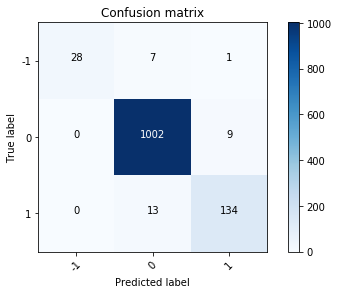

In [41]:
# make the predictions (y_hat) for the whole dataset
y_hat = knn_classifier.predict(rn_wine_X5)
# create the confusion matrix
cnf_matrix = confusion_matrix(rn_wine_y_class, y_hat)
# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=np.unique(rn_wine_y_class))

### Training with 4 features (ExtraTreesClassifier Result)
* Transform the Dataset; Train; Compute Accuracy and Confusion Matrices
* Logistic Regression

In [42]:
# Transform the Dataset 1 6 9 10
usefulFeatures = [False, True, False, False, False, False, True, False, False, True, True]
rn_wine_X4 = rn_wine_X[:,usefulFeatures]

In [43]:
regressor = LogisticRegression(solver='newton-cg', n_jobs=-1)
accuracy = np.array([])

for train_index, test_index in tqdm_notebook(rkf.split(rn_wine_X4), total=rkf.get_n_splits()):
    x_train, x_test = rn_wine_X4[train_index], rn_wine_X4[test_index]
    y_train, y_test = rn_wine_y[train_index], rn_wine_y[test_index]
    regressor.fit(x_train,y_train)
    accuracy = np.append(accuracy, [regressor.score(x_test,y_test)])

print ("Accuracy: {}%".format(accuracy.mean() * 100))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))


Accuracy: 59.046798635772305%


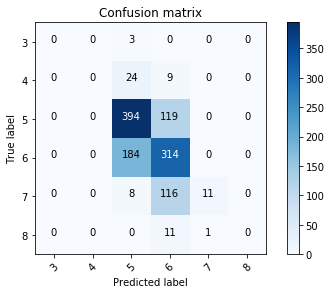

In [44]:
# make the predictions (y_hat) for the whole dataset
y_hat = regressor.predict(rn_wine_X4)
# create the confusion matrix
cnf_matrix = confusion_matrix(rn_wine_y, y_hat)
# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=np.unique(rn_wine_y))

* k-Nearest Neighbor Classifier

In [47]:
knn_classifier = KNeighborsClassifier(n_neighbors=7, weights='distance', p=2, metric='minkowski', n_jobs=-1)
accuracy = np.array([])

for train_index, test_index in tqdm_notebook(rkf.split(rn_wine_X4)):
    x_train, x_test = rn_wine_X4[train_index], rn_wine_X4[test_index]
    y_train, y_test = rn_wine_y_class[train_index], rn_wine_y_class[test_index]
    knn_classifier.fit(x_train,y_train)
    accuracy = np.append(accuracy, [knn_classifier.score(x_test,y_test)])

print ("Accuracy: {}%".format(accuracy.mean() * 100))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Accuracy: 89.0456031785099%


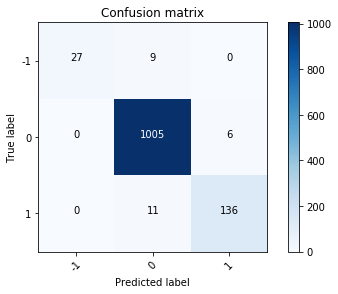

In [48]:
# make the predictions (y_hat) for the whole dataset
y_hat = knn_classifier.predict(rn_wine_X4)
# create the confusion matrix
cnf_matrix = confusion_matrix(rn_wine_y_class, y_hat)
# plot the confusion matrix
plot_confusion_matrix(cnf_matrix, classes=np.unique(rn_wine_y_class))

## Benchmarking (Accuracy) Table

| | Training \w All Features | Training \w 5 Features (via SelectKBest) | Training \w 4 Features (via ExtraTreesClassifier) |
| --- | --- | --- | --- |
| Logistic Regression (Accuracy %) | 60.0364 | 59.5169 | 59.0467 |
| K-Nearest Neighbors (Accuracy %) | 87.5046 | 87.8562 | 89.0456 |